# Import packages

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import plotly.express as px

from torchvision.utils import make_grid, save_image
from PIL import Image

# Load MNIST dataset
from data import train_loader, test_loader

# Build AutoEncoder

In [2]:
# Very Simple, huh?
class AutoEncoder(nn.Module):
    def __init__(self, img_size=28):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(img_size * img_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, img_size * img_size),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Train

Let's use Adam optimizer and MSE loss function. 

In [3]:
# Check whether gpu is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device: {}".format(device))

Using device: cuda


In [4]:
# Thanks, Copilot!
model = AutoEncoder(img_size=28).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

for epoch in range(10):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print("epoch [{}/{}], loss:{:.4f}".format(epoch + 1, 10, loss.item()))

epoch [1/10], loss:0.1828
epoch [2/10], loss:0.1626
epoch [3/10], loss:0.1683
epoch [4/10], loss:0.1550
epoch [5/10], loss:0.1396
epoch [6/10], loss:0.1561
epoch [7/10], loss:0.1310
epoch [8/10], loss:0.1264
epoch [9/10], loss:0.1521
epoch [10/10], loss:0.1494


# Eval - Check the loss

In [5]:
_ = model.eval()
model = model.to("cpu")

loss = []
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        output = model(img)
        loss.append(criterion(output, img).item())

print("test loss: {:.4f}".format(np.array(loss).mean()))

test loss: 0.1373


# Eval - Feature Representation

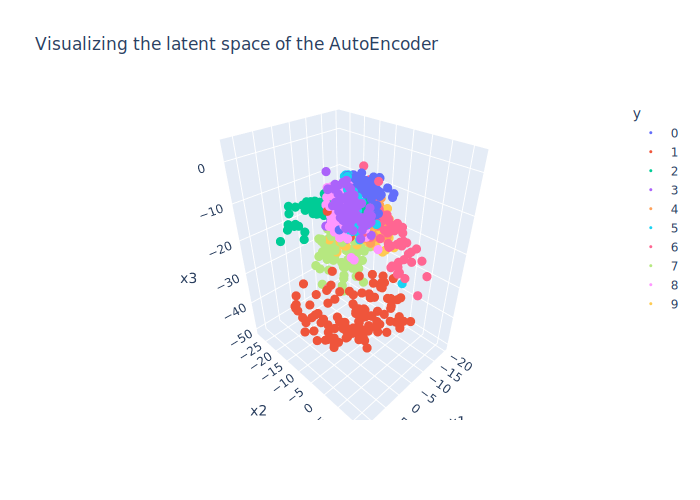

In [6]:
X = []
y = []

with torch.no_grad():
    for data in test_loader:
        img, y_real = data
        X.append(model.encoder(img.view(img.size(0), -1)).numpy())
        y.append(y_real.numpy())

X = np.concatenate(X)
y = np.concatenate(y)

df = pd.DataFrame(data=X, columns=["x1", "x2", "x3"])
df["y"] = y
df["y"] = df["y"].astype("category")

fig = px.scatter_3d(df.sample(n=1000).sort_values('y'), x='x1', y='x2', z='x3',
              color='y', title='Visualizing the latent space of the AutoEncoder')
fig.update_traces(marker_size = 3)

fig.show("svg")
fig.write_image("images/ae-fig1.png")

# Eval - Reconstruction

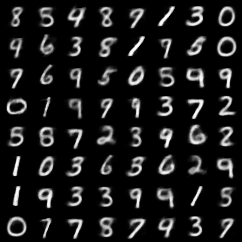

In [7]:
with torch.no_grad():
    for data in test_loader:
        img, y_real = data
        output = model(img.view(img.size(0), -1))
        break

img_grid = make_grid(output.reshape(-1, 1, 28, 28), nrow=8, normalize=True)
save_image(img_grid, "images/ae-fig2.png")
Image.open("images/ae-fig2.png")